In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torchvision.models import resnet18, ResNet18_Weights, ResNet
import gzip
import random

from torchvision import transforms
from PIL import Image

### Creating a customized Linear Layer and modified ResNet

The `ShuffledLinear` class extends the `nn.modules.Linear` class and gives it an alternate forward method which shuffles the weights column-wise before matrix multiplication.

The `ShuffledResnet18` class extending the `nn.Module` superclass copies the layout (and weights) of a pretrained `resnet18` net, and swaps the last (Linear) layer for the `ShuffledLinear` layer, and initializes its weights and biases by copying them from the original Linear layer of resnet18.

In [19]:
class ShuffledLinear(nn.modules.Linear):
    def __init__(self, *args):
        super(ShuffledLinear, self).__init__(*args)
    def forward(self, input: Tensor) -> Tensor:
        indices = torch.argsort(torch.rand_like(self.weight.T), dim=-1)
        shuffled_W_T = torch.gather(self.weight.T, dim=-1, index=indices)
        shuffled_W = shuffled_W_T.T
        return F.linear(input, shuffled_W, self.bias)

In [20]:
class ShuffledResnet18(nn.Module):
    def __init__(self, weights):
        super(ShuffledResnet18, self).__init__()
        self.resnet_model = resnet18(weights=weights)
        self.layers = []
        for i, child in enumerate(self.resnet_model.children()):
            if i == len(list(self.resnet_model.children())) - 1:
                modified_layer = ShuffledLinear(512, 1000, True)
                modified_layer.weight = child.weight
                modified_layer.bias = child.bias
                self.layers.append(modified_layer)
            else:
                self.layers.append(child)
            pass
        
    def forward(self, x: Tensor) -> Tensor:
        for i, layer in enumerate(self.layers):
            if i == len(self.layers) - 1:
                x = torch.flatten(x, 1)
            x = layer(x)
        return x

In [21]:
def print_topk(pred, k, categories):
    probabilities = torch.nn.functional.softmax(pred[0], dim=0)
    topk_prob, topk_catid = torch.topk(probabilities, 5)
    for i in range(topk_prob.size(0)):
        print(categories[topk_catid[i]], topk_prob[i].item())

In [22]:
with open("../data/resnet18_set/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [23]:
def image_to_tensor(image, reshape_dims=(224, 224)):
    transform_pipe = transforms.Compose([
        transforms.Resize(reshape_dims),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])
    img_tensor = transform_pipe(image)
    return torch.unsqueeze(img_tensor, 0)


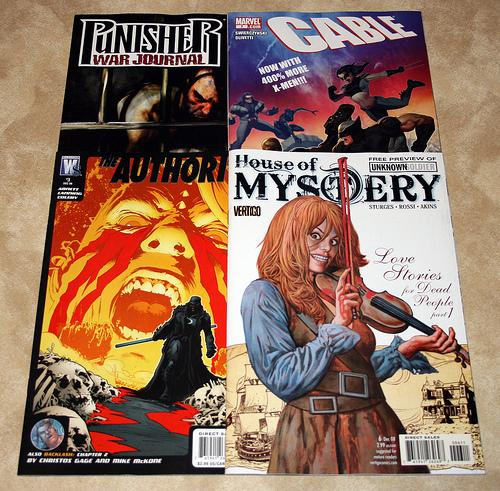

In [24]:
img = Image.open("../data/resnet18_set/image.jpg")
img_tensor = image_to_tensor(img)
img



In [25]:
res = resnet18(weights=ResNet18_Weights.DEFAULT)
res.eval()
pred = res.forward(img_tensor)
print_topk(pred=pred, k=5, categories=categories)

comic book 0.8439626097679138
book jacket 0.14433899521827698
packet 0.002949686488136649
jigsaw puzzle 0.002197999507188797
menu 0.0009636227041482925


In [26]:
model = ShuffledResnet18(weights=ResNet18_Weights.DEFAULT)
model.eval()
pred = model.forward(img_tensor)
print_topk(pred=pred, k=5, categories=categories)

seat belt 0.10287684202194214
ping-pong ball 0.06438273191452026
platypus 0.036406856030225754
fire screen 0.03583010286092758
ski 0.035020649433135986


### Creating a Shuffled Linear Layer with variable number of shuffled neurons

In [27]:
class ShuffledLinearVariable(nn.modules.Linear):
    def __init__(self, *args, n_shuffled=None, printing=False):
        super(ShuffledLinearVariable, self).__init__(*args)
        self.n_shuffled = n_shuffled if (n_shuffled is not None and n_shuffled < self.in_features) else self.in_features
        self.printing = printing

    def change_n_shuffled(self, n_shuffled: int):
        self.n_shuffled = n_shuffled if (n_shuffled is not None and n_shuffled < self.in_features) else self.in_features
        return self.n_shuffled
    
    def forward(self, input: Tensor) -> Tensor:
        randomization = torch.rand_like(self.weight.T)
        indices = torch.argsort(randomization, dim=-1)

        if self.printing: print(f"Indices:\n{indices}")
        if self.n_shuffled < self.in_features:
            rows_to_sort = random.sample(range(self.in_features), (self.in_features - self.n_shuffled))
            sorted_rows, _ = torch.sort(indices[rows_to_sort], dim=1)
            indices[rows_to_sort] = sorted_rows
            if self.printing: print(f"Rows to unshuffle:\n{rows_to_sort}\nIndices:\n{indices}")

        shuffled_W_T = torch.gather(self.weight.T, dim=-1, index=indices)
        shuffled_W = shuffled_W_T.T
        return F.linear(input, shuffled_W, self.bias)

In [28]:
class ShuffledResnet18Variable(nn.Module):
    def __init__(self, weights):
        super(ShuffledResnet18Variable, self).__init__()
        self.resnet_model = resnet18(weights=weights)
        self.layers = []
        self.modified_layer: ShuffledLinearVariable = None
        for i, child in enumerate(self.resnet_model.children()):
            if i == len(list(self.resnet_model.children())) - 1:
                modified_layer = ShuffledLinearVariable(512, 1000, True)
                modified_layer.weight = child.weight
                modified_layer.bias = child.bias
                self.layers.append(modified_layer)
                self.modified_layer = self.layers[-1]
            else:
                self.layers.append(child)
            pass
    
    def change_n_shuffled(self, n_shuffled: int):
        return self.modified_layer.change_n_shuffled(n_shuffled=n_shuffled)

    def forward(self, x: Tensor) -> Tensor:
        for i, layer in enumerate(self.layers):
            if i == len(self.layers) - 1:
                x = torch.flatten(x, 1)
            x = layer(x)
        return x

In [29]:
test_input_size, test_output_size = (8, 3)
test_input = torch.rand(test_input_size)
test_linear = ShuffledLinearVariable(test_input_size, test_output_size, n_shuffled=3, printing=True)
test_linear.forward(test_input)

Indices:
tensor([[0, 1, 2],
        [1, 0, 2],
        [2, 0, 1],
        [2, 1, 0],
        [1, 0, 2],
        [2, 0, 1],
        [2, 1, 0],
        [2, 1, 0]])
Rows to unshuffle:
[6, 1, 7, 0, 2]
Indices:
tensor([[0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        [2, 1, 0],
        [1, 0, 2],
        [2, 0, 1],
        [0, 1, 2],
        [0, 1, 2]])


tensor([ 0.2501,  0.0979, -0.4827], grad_fn=<AddBackward0>)

### Loading the Dataset

In [30]:
import os
print(len(os.listdir("../data/resnet18_set/images_unpacked")))

50000


In [31]:
transform_pipe = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

In [33]:
from torchvision.datasets import ImageFolder

train_set = ImageFolder("../data/resnet18_set/images_unpacked/", transform=transform_pipe)


FileNotFoundError: Couldn't find any class folder in ../data/resnet18_set/images_unpacked.